## MNIST Pytorch

#### 在运行之前，应满足如下库的需求，并在工作区下载data源文件

In [2]:
!pip3 install torch
!pip3 install numpy
!pip3 install matplotlib

### 若机器配备gpu

In [49]:
print(torch.cuda.is_available())
device = "cuda:0" if torch.cuda.is_available()  else "cpu"

True


根据数据存放位置，修改配置信息。

In [0]:
# 需要配置
train_data_file = '/content/drive/My Drive/CNN-MNIST/data/train/train-images-idx3-ubyte'
train_label_file = '/content/drive/My Drive/CNN-MNIST/data/train/train-labels-idx1-ubyte'
test_data_file = '/content/drive/My Drive/CNN-MNIST/data/test/t10k-images-idx3-ubyte'
test_label_file = '/content/drive/My Drive/CNN-MNIST/data/test/t10k-labels-idx1-ubyte'

#### 可视化工具，包括进度条和图片显示工具

In [0]:
import time
class Progress_bar(object):
    def __init__(self):
        self.start = time.perf_counter()
        self.last_update = time.perf_counter()

    def bar(self, index, length, script, batch=1):
        index = index * batch
        if length - index < batch:
            index = length-1
        percentage = (index+1) / length
        progress = list('..........................')
        progress[(index+1) * 25//length] = '>'
        progress[:(index+1) * 25//length] = '=' * ((index+1) * 25//length + 1)
        progress = ''.join(progress)
        end_time = time.perf_counter()
        print("\r{}: {}  time left:{:.2f}s {}/{}  {:.2f} {} time cost:{:.2f}s "
              .format(script,
                      progress,
                      (end_time - self.start) / percentage * (1 - percentage),
                      (index+1), length, percentage * 100, "%", end_time - self.start), end='')
        self.last_update = time.perf_counter()


In [0]:
# %matplotlib inline
import matplotlib.pyplot as plt
def show_image(array, rows=1, cols=1):
    if rows * cols == 1:
        plt.figure()
        plt.imshow(array, cmap='gray')
        plt.show()
    else:
        for row in range(rows):
            for col in range(cols):
                index = row * cols + col 
                plt.subplot(rows, cols, index+1)
                plt.imshow(array[index], cmap="gray", interpolation="nearest")
                plt.axis('off')
        plt.show()
 


#### 数据的预处理函数

In [0]:
import struct
import numpy as np

def raw_file_idx3_process(file_path):
    with open(file_path, 'rb') as f:
        binary_data = f.read()
        off_set = 0
        fmt_header = '>iiii'
        magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, binary_data, off_set)

        image_size = num_rows * num_cols
        off_set += struct.calcsize(fmt_header)
        fmt_image = '>' + str(image_size) + 'B'
        images = np.empty((num_images, 1,  num_rows, num_cols))

        print("\nfile idx3 decoding:")
        b = Progress_bar()
        for i in range(num_images):
            b.bar(i, num_images, "Preprocessed ")
            temp = np.array(struct.unpack_from(fmt_image, binary_data, off_set)).reshape((num_rows, num_cols)).reshape(-1,1)
            temp = temp / 255
            temp = temp.reshape(1, 28, 28)
            images[i][0] = temp
            off_set += struct.calcsize(fmt_image)
    return images

In [0]:
def raw_file_idx1_process(file_path):
    with open(file_path, 'rb') as f:
        binary_data = f.read()
        off_set = 0
        fmt_header = '>ii'
        magic_number, num_labels = struct.unpack_from(fmt_header, binary_data, off_set)

        off_set += struct.calcsize(fmt_header)
        fmt_label = '>B'
        labels = np.empty(num_labels)

        print("\nfile idx1 decoding:")
        b = Progress_bar()
        for i in range(num_labels):
            b.bar(i, num_labels, "Preprocessed ")
            labels[i] = np.array(struct.unpack_from(fmt_label, binary_data, off_set), dtype=np.int)
            off_set += struct.calcsize(fmt_label)
    return labels

#### Pytorch 数据处理 构建dataset

In [0]:
import torch
import torch.utils.data as tud

class Torch_data_set(tud.Dataset):
    def __init__(self, data, label):
        super(Torch_data_set, self).__init__()
        self.data = data
        self.label = label

    def __len__(self):
        if len(self.data) == len(self.label):
            return len(self.data)
        else:
            raise ValueError("wrong input size")

    def __getitem__(self, index):
        tensor_data = torch.from_numpy(self.data)[index]
        tensor_label = torch.from_numpy(self.label)[index]
        return tensor_data.type(torch.float32), tensor_label.type(torch.int64)

### 模型构建 卷积神经网络

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.Conv1 = nn.Conv2d(1, 20, 5, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.Conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.Conv1(x))
        x = self.pool(x)
        x = F.relu(self.Conv2(x))
        x = self.pool(x)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

        

#### 训练模型

In [52]:
NUM_EPOCHS = 2
BATCH_SIZE = 128


train_data = raw_file_idx3_process(train_data_file)
train_label = raw_file_idx1_process(train_label_file)
train_set = Torch_data_set(train_data, train_label)
train_loader = tud.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

net = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

net = net.to(device)

for epoch in range(NUM_EPOCHS):
    print("\nepoch: ", epoch+1)
    b = Progress_bar()
    for index, data in enumerate(train_loader):
        b.bar(index, train_set.__len__(), "Training: ", BATCH_SIZE)
        image, label = data
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        predict = net(image)
        loss = loss_fn(predict, label)
        print("loss: ", torch.sum(loss).cpu().item(), end='')
        loss.backward()
        optimizer.step()




file idx3 decoding:
Preprocessed : ==========================>  time left:0.00s 60000/60000  100.00 % time cost:14.20s 
file idx1 decoding:
Preprocessed : ==========================>  time left:0.00s 60000/60000  100.00 % time cost:7.01s 
epoch:  1
Training: : ==========================>  time left:0.00s 60000/60000  100.00 % time cost:2.02s loss:  0.05814843997359276
epoch:  2
Training: : ==========================>  time left:0.00s 60000/60000  100.00 % time cost:1.97s loss:  0.02134430967271328

#### 模型测试


file idx3 decoding:
Preprocessed : ==========================>  time left:0.00s 10000/10000  100.00 % time cost:2.36s 
file idx1 decoding:
Preprocessed : ==========================>  time left:0.00s 10000/10000  100.00 % time cost:1.17s 

Accuracy: 0.98[8 7 3 7 2 7 0 2 4 1]


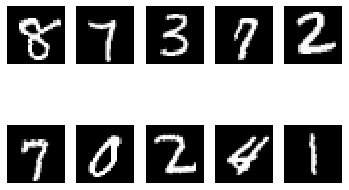

Accuracy: 0.98

In [53]:

BATCH_SIZE = 10

test_data = raw_file_idx3_process(test_data_file)

test_label = raw_file_idx1_process(test_label_file)

test_set = Torch_data_set(test_data, test_label)
test_loader = tud.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

total = 0
bingo = 0

print("\n")
with torch.no_grad():
    for index, data in enumerate(test_loader):
        inputs, label = data
        inputs, label = inputs.to(device), label.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data,1)
        total += label.size(0)
        bingo += (predicted == label).sum().item()
        if index == 117:
            print(predicted.cpu().numpy())
            inputs = [inp.reshape(28, 28) for inp in inputs.cpu()]
            show_image(inputs, 2, 5)
            
        print("\rAccuracy: {:.2f}".format(bingo/total), end='')
